## Dataset generation from deformable mirror

A Parabolic GRIN fiber or a Step-Index fiber can be used

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.datasets import SimulatedGrinSpeckleOutputDataset, SimulatedStepIndexSpeckleOutputDataset, SimulatedSpeckleOutputDataset

### Setup

Set the computation grid and the fiber characteristics

In [2]:
fiber_type: str = 'step' # 'grin' or 'step'
grid_settings: dict = {'pixel_size': 0.25e-6, 'pixel_numbers': (256, 256)}
fiber_settings: dict = {'radius': 25e-6, 'wavelength': 1064e-9, 'n1': 1.465, 'n2': 1.45}
dataset_settings: dict = {'length': 1000, 'degen': True, 'phases_dim': (6, 6)}
fourier_settings: dict = {'pad': 2}
export_settings: dict = {'return_output_fields': True, 'add_exp_noise': True, 'noise_func': np.median, 'file_type': 'hdf5'}

### Dataset generation

Generate the grid and the fiber

In [3]:
grid = Grid(**grid_settings)

if fiber_type.lower() in ['grin']:
    fiber = GrinFiber(**fiber_settings)
elif fiber_type.lower() in ['step', 'si']:
    fiber = StepIndexFiber(**fiber_settings)
else:
    raise ValueError(f"Unknown fiber type.")
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.465
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.209
  - Number of guided LP modes: 127
  - Number of guided LP modes (counting degenerates): 244
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46491504  0.          0.          1.        ]
 [ 1.46478431  2.          1.          1.        ]
 [ 1.46461254  4.          2.          1.        ]
 [ 1.46455239  1.          0.          2.        ]
 [ 1.46440201  6.          3.          1.        ]
 [ 1.46427707  3.          1.          2.        ]
 [ 1.46415411  8.          4.          1.        ]
 [ 1.46395943  5.          2.          2.        ]
 [ 1.46390022  2.          0.          3.        ]
 [ 1.46386979 10.          5.          1.        ]]


Compute and store the modes for a much faster dataset generation, plot one for checking extent

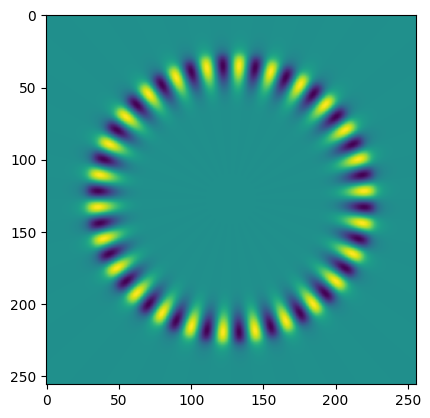

In [4]:
fiber.compute_modes_fields(grid)
plt.imshow(fiber._modes[:,:,1,-1])

Compute dataset

In [5]:
dset = SimulatedStepIndexSpeckleOutputDataset(fiber, grid, N_modes=fiber._N_modes_degen, length=dataset_settings['length'])
dset.compute_from_transfer_matrix(phases_dim=dataset_settings['phases_dim'])
# dset.compute_fourier_transforms(**fourier_settings)

Computed TM row 1/36
Computed TM row 2/36
Computed TM row 3/36
Computed TM row 4/36
Computed TM row 5/36
Computed TM row 6/36
Computed TM row 7/36
Computed TM row 8/36
Computed TM row 9/36
Computed TM row 10/36
Computed TM row 11/36
Computed TM row 12/36
Computed TM row 13/36
Computed TM row 14/36
Computed TM row 15/36
Computed TM row 16/36
Computed TM row 17/36
Computed TM row 18/36
Computed TM row 19/36
Computed TM row 20/36
Computed TM row 21/36
Computed TM row 22/36
Computed TM row 23/36
Computed TM row 24/36
Computed TM row 25/36
Computed TM row 26/36
Computed TM row 27/36
Computed TM row 28/36
Computed TM row 29/36
Computed TM row 30/36
Computed TM row 31/36
Computed TM row 32/36
Computed TM row 33/36
Computed TM row 34/36
Computed TM row 35/36
Computed TM row 36/36
Computed couple 1/1000
Computed couple 2/1000
Computed couple 3/1000
Computed couple 4/1000
Computed couple 5/1000
Computed couple 6/1000
Computed couple 7/1000
Computed couple 8/1000
Computed couple 9/1000
Computed c

### Dataset checking and export

Display a random draw from the dataset as a check

Text(0.5, 1.0, 'Far field intensity')

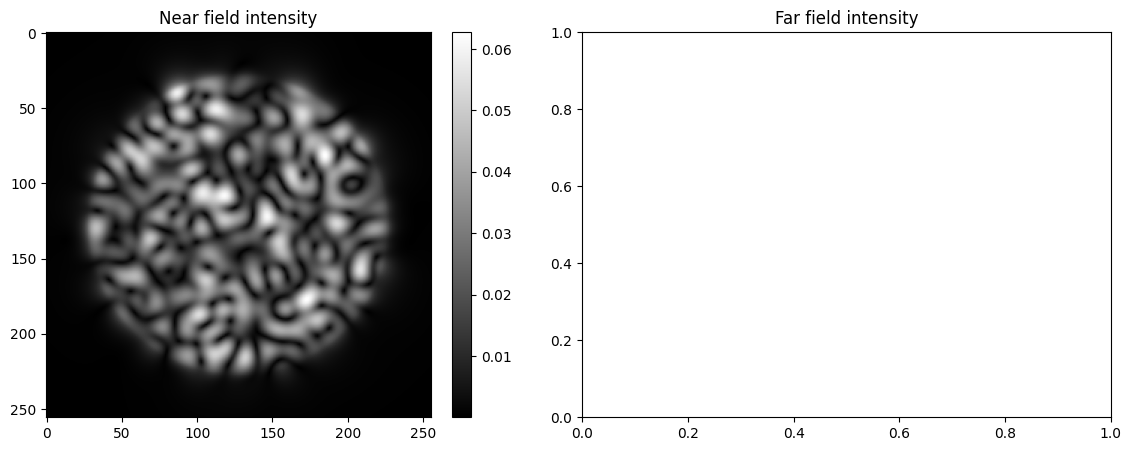

In [41]:
rand_idx = np.random.randint(0, dset._fields.shape[-1])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
nf = axs[0].imshow(np.sqrt(dset.intensities[..., rand_idx]), cmap='gray')
# ff = axs[1].imshow((np.abs(dset._transf[..., rand_idx])), cmap='gray')
plt.colorbar(nf, ax=axs[0], fraction=0.046, pad=0.04)
# plt.colorbar(ff, ax=axs[1], fraction=0.046, pad=0.04)
axs[0].set_title('Near field intensity')
axs[1].set_title('Far field intensity')

In [26]:
m2, n = dset.reshaped_transfer_matrix.shape
m = int(np.sqrt(m2))
N = 10000



phi = 2 * np.pi * np.random.rand(n)
x = np.ones((n, N), dtype=np.complex64)
for i in range(N):
    phi += 0.1 * np.random.randn(n)
    x[:, i] = x[:, i] * np.exp(1j * phi)



# x = np.ones((n, N)) * np.exp(1j * 2 * np.pi * np.random.rand(n, N))
y = dset.reshaped_transfer_matrix @ x
y = np.square(np.abs(y.reshape((m, m, N))))
# y = y[0, ...].reshape((m, m))

y = np.moveaxis(y, -1, 0)
# plt.imshow(np.abs(y), cmap='gray')

In [27]:
from waveoptics.plots.plots import animate_images
import matplotlib.animation as animation



def animate_images(speckles: np.ndarray, savepath: str, figsize: tuple[float, float]) -> None:
    frames = speckles.shape[0]
    size = speckles.shape[1:]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot([0, 1], [0, 1], label='Full Figure Axes', ls='none')
    ax.axis('off')

    # fig.set_facecolor('black')
    img = plt.imshow(np.zeros(shape=size), cmap='gray')
    img.set_clim(vmin=0, vmax=1)
    # plt.axis('off')

    def animate(frame):
        speckle = speckles[frame, ...]
        speckle /= np.max(np.abs(speckle))
        img.set_data(speckle)
        # img.set_clim(vmin=0, vmax=1)

    anim_created = animation.FuncAnimation(fig, animate, frames=frames, interval=1000/60, repeat=True)
    anim_created.save(savepath,)
    plt.close()


animate_images(speckles=y, savepath='video_speckle.mp4', figsize=(5,5))

Export it if it looks ok

In [27]:
dset.export(**export_settings, max_fields_per_file=10000)

Dataset saved: .\synth_dset_step_lambda=1064nm_Nmodes=106_degen=True_len=1000_mirr=36_exp_noise_1_of_1.hdf5
